In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

In [3]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_temporal.npy'
temporal = np.load(file)
temporal = temporal*-1
temporal.shape #timepoint by PC

(30456, 1000)

In [4]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [5]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)
            
            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1
            
            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)
            
            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [10]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1
            
            ### 50Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 20
            x_hz50 = np.arange(0,expt_len,sample_in_ms)
            hz50_res_behavior = self.pull_from_interp_object(interp_object, x_hz50)
            self.fictrac[short + '_50hz'] = hz50_res_behavior
#             self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
#             self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [11]:
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.81 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.71 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.71 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.77 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.62 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.79 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.81 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.79 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.82 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.78 sec
*** fly: fly_09

In [ ]:
# z = 20
# sphere_radius = 4.5e-3 # in m
# fps=50
# behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
# behavior_super = {}
# for behavior in behaviors:
#     behavior_super[behavior] = []
#     for fly in fly_names:
#         behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
#     behavior_super[behavior] = np.asarray(behavior_super[behavior])
#     behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
#     if behavior in ['Y', 'Y_pos']:
#         ''' starts with units of rad/frame
#         * sphere_radius(m); now in m/frame
#         * fps; now in m/sec
#         * 1000; now in mm/sec '''
#         behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
#     elif behavior in ['Z', 'Z_pos', 'Z_neg']:
#         ''' starts with units of rad/frame
#         * 180 / np.pi; now in deg/frame
#         * fps; now in deg/sec '''
#         behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [13]:
### 50 Hz version for video sync ###

z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y_50hz', 'Z_50hz']

behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior in ['Y_50hz']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z_50hz']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [14]:
behavior_super['Y_50hz'].shape

(810000,)

In [17]:
flies['fly_098'].fictrac.fictrac['Y_50hz'].shape

(90000,)

In [2]:
cap = cv2.VideoCapture('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_098/func_0/fictrac/fictrac-20200627_130208-raw.avi')
i=0
frames = []
ret = True
while ret is True and i<90000:
    i+=1
    if i%1000 == 0:
        print(i)
    # Capture frame-by-frame
    ret, frame = cap.read()
    frames.append(frame)
cap.release()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000


In [21]:
fly_num = 4
start = fly_num*3384
end = (fly_num+1)*3384

fly_pcs = temporal[start:end,:3]
fly_pcs.shape

(3384, 3)

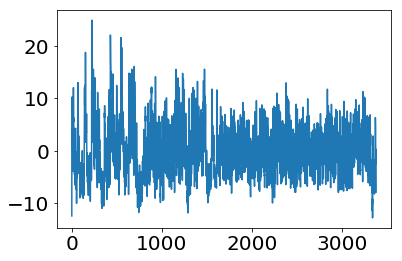

In [22]:
plt.plot(fly_pcs[:,0])

In [27]:
#interp PCs to video rate
expt_len = 1000*30*60
resolution = 532
x_original = np.arange(0,expt_len,resolution)
interp_object = interp1d(x_original, fly_pcs.T, bounds_error = False)

expt_len = 1000*30*60
resolution = 532
x_new = np.arange(0,expt_len,20)
pcs_50hz = interp_object(x_new)
pcs_50hz.shape

(3, 90000)

In [49]:
frames[frame_num][50:250,200:-200]

array([[[ 64,  67,  65],
        [ 64,  67,  65],
        [ 63,  66,  64],
        ...,
        [ 19,  19,  19],
        [ 19,  19,  19],
        [ 19,  19,  19]],

       [[ 68,  71,  69],
        [ 65,  68,  66],
        [ 62,  65,  63],
        ...,
        [ 15,  15,  15],
        [ 13,  13,  13],
        [ 13,  13,  13]],

       [[ 73,  76,  74],
        [ 71,  74,  72],
        [ 64,  67,  65],
        ...,
        [  8,   8,   8],
        [  5,   5,   5],
        [  3,   3,   3]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [250, 253, 251],
        [250, 253, 251],
        [250, 253, 251]],

       [[  4,   4,   4],
        [ 20,  20,  20],
        [ 27,  27,  27],
        ...,
        [250, 253, 251],
        [250, 253, 251],
        [250, 253, 251]],

       [[ 43,  43,  43],
        [ 45,  45,  45],
        [ 48,  48,  48],
        ...,
        [250, 253, 251],
        [250, 253, 251],
        [250, 253, 251]]

In [75]:
def increase_brightness(img, value=20):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [115]:
from tqdm import tqdm

In [ ]:
fig = plt.figure(figsize=(10,10))

window = 1000 # in units of frames (20ms). So, 1000 is 1000*20 = 20sec
frame_num = 30000

for frame_num in tqdm(range(0,90000,2),position=0, leave=True):
    ax1 = fig.add_axes([0, .5, .5, .5]) #left bottom width height
    ax1.imshow(increase_brightness(frames[frame_num][50:250,200:-200]))
    ax1.axis('off')

    ### Zoom in views ###

    ax2 = fig.add_axes([0, .4, 1, .2])
    ax2.plot(pcs_50hz[0,:],color='k')
    ax2.set_xlim(frame_num-window, frame_num+window)
    ax2.axvline(frame_num, color='k', linestyle='--')
    plt.axis('off')

    ax3 = fig.add_axes([0, .2, 1, .2])
    ax3.plot(flies['fly_098'].fictrac.fictrac['Y_50hz'], color=(0,0,1))
    ax3.plot(pcs_50hz[1,:]/-200,color='k')
    ax3.set_xlim(frame_num-window, frame_num+window)
    ax3.axvline(frame_num, color='k', linestyle='--')
    plt.axis('off')

    ax4 = fig.add_axes([0, 0, 1, .2])
    ax4.plot(flies['fly_098'].fictrac.fictrac['Z_50hz'], color=(1,0,0))
    ax4.plot(pcs_50hz[2,:]/-100,color='k')
    ax4.set_xlim(frame_num-window, frame_num+window)
    ax4.axvline(frame_num, color='k', linestyle='--')
    plt.axis('off')


    ### Zoom out views ###

    ax = fig.add_axes([.5, .6, .5, .5/3])
    ax.plot(flies['fly_098'].fictrac.fictrac['Z_50hz'],color=(1,0,0))
    ax.axvline(frame_num, color='k', linestyle='--')
    ax.set_xlim(0,90000)
    plt.axis('off')

    ax = fig.add_axes([.5, .6+.5/3, .5, .5/3])
    ax.plot(flies['fly_098'].fictrac.fictrac['Y_50hz'],color=(0,0,1))
    ax.axvline(frame_num, color='k', linestyle='--')
    ax.set_xlim(0,90000)
    plt.axis('off')

    ax = fig.add_axes([.5, .6+.5/3+.5/3, .5, .5/3])
    ax.plot(pcs_50hz[0,:],color='k')
    ax.axvline(frame_num, color='k', linestyle='--')
    ax.set_xlim(0,90000)
    plt.axis('off')

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20211116_behavior_video/frames'
    fname = os.path.join(save_path, '{0:06d}.png'.format(frame_num))
    plt.savefig(fname,dpi=30,bbox_inches='tight')
    
    plt.clf()

 37%|███▋      | 16491/45000 [3:56:43<7:35:08,  1.04it/s] 

In [112]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20211116_behavior_video/frames'
os.mkdir(save_path)

NameError: name 'temporal_super' is not defined

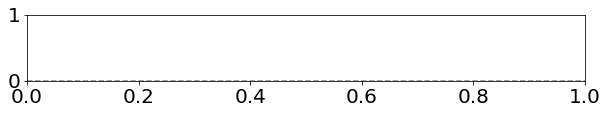

In [53]:
plt.figure(figsize=(10,10))
start = 8000
end = 9000

for i in range(7):
    plt.subplot(7,1,i+1)
    plt.axhline(0,color='grey',linestyle='--')
    if i == 6:
        plt.plot(behavior_super['Y_pos_units'][start:end],color='k')
        #plt.ylabel('Vf',rotation = 0,x=-100)
        ax = plt.gca()
        ax.set_yticks([])
    if i<6:
        plt.plot(temporal_super[start:end,i],color='k')
        #plt.ylabel(f'PC{i+1}',rotation = 0,x=-1000)
        ax = plt.gca()
        ax.set_yticks([])
        plt.axis('off')
    ax = plt.gca()
    ax.set_xticks([0,200,400,600,800,1000])
    ax.set_xticklabels([0,100,200,300,400,500])
    
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel("time, sec")

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [89]:
flies

{'fly_087': <__main__.Fly at 0x7f74fcc82828>,
 'fly_089': <__main__.Fly at 0x7f74f2303908>,
 'fly_094': <__main__.Fly at 0x7f74f18e4ba8>,
 'fly_097': <__main__.Fly at 0x7f74f0f33940>,
 'fly_098': <__main__.Fly at 0x7f74f052f908>,
 'fly_099': <__main__.Fly at 0x7f74efb7c940>,
 'fly_100': <__main__.Fly at 0x7f74ef14dba8>,
 'fly_101': <__main__.Fly at 0x7f74ee79b978>,
 'fly_105': <__main__.Fly at 0x7f74df570940>}

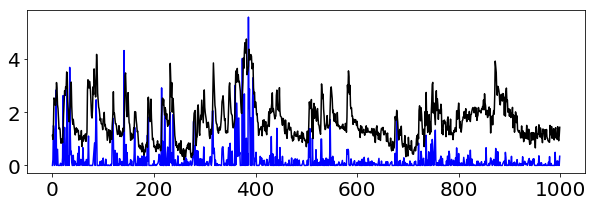

In [109]:
plt.figure(figsize=(10,3))
fly_num = 8
section = 2
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

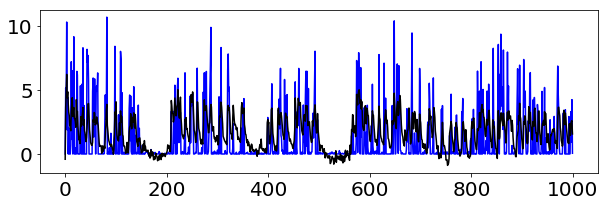

In [96]:
plt.figure(figsize=(10,3))
fly_num = 6
section = 0
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

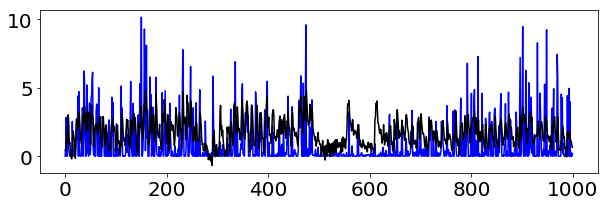

In [88]:
plt.figure(figsize=(10,3))
fly_num = 4
section = 1
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

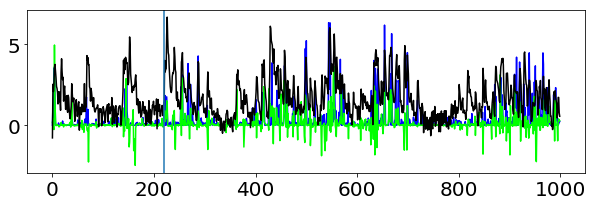

In [118]:
plt.figure(figsize=(10,3))
fly_num = 4
section = 0
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot(behavior_super['Z_units'][start:end]/100,color=(0,1,0))

plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

plt.axvline(220)

(600, 1000)

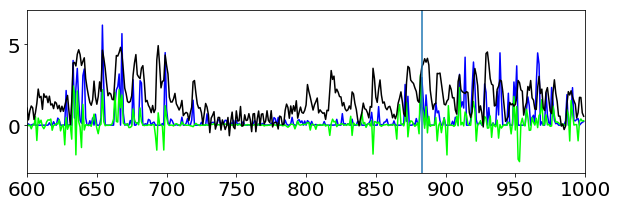

In [159]:
plt.figure(figsize=(10,3))
fly_num = 4
section = 0
start = fly_num*3384+1000*section
end = fly_num*3384+1000*section+1000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot(behavior_super['Z_units'][start:end]/100,color=(0,1,0))

plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

plt.axvline(4)
plt.axvline(38)
plt.axvline(67)
plt.axvline(883)

plt.xlim(600,1000)

In [131]:
def frame_num_to_video_time(frame_num):
    frame_rate = 0.532
    print(frame_num*frame_rate)

In [150]:
def video_time_to_frame_num(m, s):
    secs = m*60 + s
    frame_rate = 0.532
    print(secs/frame_rate)

In [158]:
video_time_to_frame_num(7, 50)

883.4586466165413


In [135]:
frame_num_to_video_time(4)
frame_num_to_video_time(38)
frame_num_to_video_time(67)

2.128
20.216
35.644000000000005


In [130]:
# frame number to video time
frame_num = 4
frame_rate = 0.532
frame_num*fram_rate

2.128

In [117]:
1000/532

1.8796992481203008

In [123]:
#one minute of video is
60/.532

112.78195488721803

In [116]:
# each step is a frame of length 532ms
(220*0.532)/60

1.9506666666666668

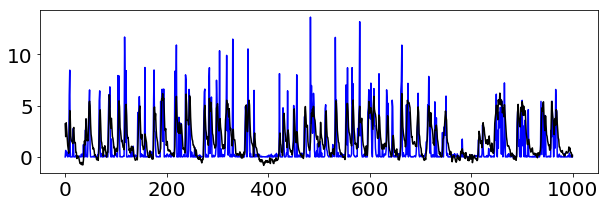

In [76]:
plt.figure(figsize=(10,3))
fly_num = 2
start = fly_num*3384+1000
end = fly_num*3384+2000
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')

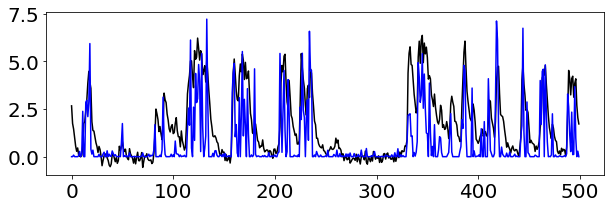

In [42]:
plt.figure(figsize=(10,3))
start = 8500
end = 9000
plt.plot((temporal_super[start:end,0]*-0.2)+1.7,color='k')
plt.plot(behavior_super['Y_pos_units'][start:end],color=(0,0,1))

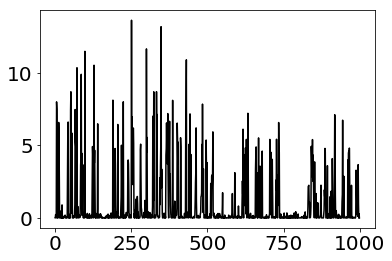

In [83]:
plt.plot(behavior_super['Y_pos_units'][start:end],color='k')